#### packages and functions

In [3]:
from pathlib import Path
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import time
import os
from scipy import signal
import matplotlib.colors as colors
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import curve_fit
from scipy.special import erf
import scipy.io
import colorsys
from scipy import signal
import math
from scipy.stats import norm
import pickle
import os
import pandas as pd

import ipyparams
import E6math
import Photontimer
import smart_gaussian2d_fit


In [4]:
from scipy.interpolate import interp1d

# def uniquebin(x, y):
#     xbin = np.unique(np.array(x).astype('float'))
#     ybin = xbin * 0;
#     ybinerr = xbin * 0;
#     for i in range(0, len(xbin)):
#         ytemplist = y[x == xbin[i]]
#         ybin[i] = np.nanmean(ytemplist)
#         ybinerr[i] = np.nanstd(ytemplist)
    
#     return xbin, ybin, ybinerr

def uniquebin(x, y):
    xbin = np.unique(np.array(x).astype('float'))
    ybin = xbin * 0;
    ybinerr = xbin * 0;
    ybinmean_err = xbin * 0;
    for i in range(0, len(xbin)):
        ytemplist = y[x == xbin[i]]
        ybin[i] = np.nanmean(ytemplist)
        ybinerr[i] = np.nanstd(ytemplist)
        ybinmean_err[i] = ybinerr[i]/np.sqrt(np.sum(x == xbin[i]))
    return xbin, ybin, ybinerr,ybinmean_err


def rabi_oscillation_t(tau,fR,phi,A=1,offset=0):
    return A*np.cos(2*np.pi*tau*fR+phi)+offset


def rabi_oscillation(tau=0, fR=3e3, delta=0, f=None, f0=None):
    if (f0 is not None) and (f is not None): delta = f0-f
    elif f0 is not None: delta=0.0
    elif f is not None: delta=0.0
    return fR**2 / (fR**2 + delta**2) * np.sin(np.pi * tau * (fR**2 + delta**2)**(1/2))**2

def rabi_oscillation_decoherence(tau=0, fR=3e3, gamma=0, Amp=1, offset=0):
    w=np.exp(-0.5*gamma*tau)*(np.cos(2*np.pi*np.sqrt(fR**2-(gamma/2)**2)*tau)+(gamma/2/np.sqrt(fR**2-(gamma/2)**2))*np.sin(2*np.pi*np.sqrt(fR**2-(gamma/2)**2)*tau))
    return Amp*(1-w)/2+offset

def butter_lowpass_filter(data, cutoff, order):
    b, a = signal.butter(order, cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y


def exp_fun_2(t,alpha,A=1,B=0):
    return A*np.exp(-2*alpha*t)+B


def exp_fun(t,gamma,A=1,B=0):
    return A*np.exp(-gamma*t)+B

x_int=np.array([0,0.7 ,0.8, 0.9, 1   ,1.1,  1.2, 1.3,  1.4,  1.5, 1.6,   1.7  ,1.8  ,2.0  ,2.1  ,2.2  ,2.5  ,3  ,3.5, 4  ,4.5,5  ,5.5,6  ,6.5,7.5,8.5,10])
y_int=np.array([0,0.99,7.18,20.7,41.3,65.3, 90.5,115.4,138.1,159.0,178.5,195.6,210.3,236.7,248.4,258.7,283.8,314,335, 349,361,370,376,383,388,397,402,408])
y_int=y_int/np.max(y_int)
power_curve= interp1d(x_int,y_int,kind='slinear')

def ControlV_Power(x,maximum_power=1):
    return maximum_power*power_curve(x)

def ControlIpower(x):
    return (2/np.pi)*(41.3/0.101)*0.6*0.02/(0.2**2) * 0.1*  ControlV_Power(x)  #mW/cm^2

def double_lorentzian_fit(f, A, B, kappa, gamma, f0):
    return A/(1+(2*(f-f0)/kappa)**2) + B/(1+(2*(f-f0)/gamma)**2)

def lorentzian_fit(f, A, kappa, f0):
    return A/(1+(2*(f-f0)/kappa)**2)

In [5]:
# simulated N scaling
# 512MHz g0=3.1MHz
N_sim=np.array([ 1,  2,  3,  4,  5,  6, 7,  8])

rel_cav_height_10nm_512MHz=np.array([ 1.        ,  3.9932454 ,  8.97666513, 15.94504205, 24.88395339,
       35.800021  , 48.67755505, 63.52935801])
rel_cav_height_130nm_512MHz=np.array([ 1.        ,  3.50127715,  7.53997985, 13.00364974, 20.4688463 ,
       28.4414432 , 38.86101047, 49.20170356])
rel_cav_height_150nm_512MHz=np.array([ 1.        ,  3.24543437,  6.4885979 , 11.24202425, 17.41620041,
       24.46064153, 32.54476083, 41.89095921])

rel_cav_weight_10nm_512MHz=np.array([ 1.        ,  3.99523801,  8.9856586 , 15.96919352, 24.93404818,
       35.88833457, 48.82018323, 63.7452156 ])
rel_cav_weight_130nm_512MHz=np.array([ 1.        ,  3.50267269,  7.54650876, 13.02259644, 20.50677823,
       28.50735218, 38.97035077, 49.3646424 ])
rel_cav_weight_150nm_512MHz=np.array([ 1.        ,  3.24677217,  6.49427329, 11.25711612, 17.4485312 ,
       24.51886691, 32.63516859, 42.02741649])


shift_sim_10nm_512MHz=np.array([-0.01894299, -0.03786727, -0.05680144, -0.07574188, -0.09466694,
       -0.11360509, -0.1325311 , -0.15147438])
shift_sim_130nm_512MHz=np.array([-0.01538429, -0.02865735, -0.04121567, -0.05446417, -0.06770355,
       -0.0797003 , -0.09273594, -0.1045913 ])
shift_sim_150nm_512MHz=np.array([-0.01513781, -0.02757617, -0.03933482, -0.05132907, -0.06360572,
       -0.07492203, -0.0868774 , -0.09839016])

width_sim_10nm_512MHz=np.array([0.53025615, 0.53051427, 0.53077022, 0.53102726, 0.53128471,
       0.53154183, 0.53179986, 0.53205581])
width_sim_130nm_512MHz=np.array([0.530239  , 0.53047341, 0.53070598, 0.53096488, 0.53119116,
       0.53142854, 0.53166353, 0.53188658])
width_sim_150nm_512MHz=np.array([0.53023666, 0.53047224, 0.53070898, 0.53093774, 0.53117223,
       0.53140884, 0.53163139, 0.53187685])


## Load data

### User input section

In [6]:
########################### User input section ############################
# run info
currentnotebook_name = ipyparams.notebook_name
run_name = currentnotebook_name[:-6]
run_name = 'run0'

#Boolean input
override_num_shots = False
reset_hard = False #only set this to true if you want to reload from raw data


#number input
# num_shots_manual = 39
num_shots_manual = 3250

num_frames = 3
# t_pre=17 #us
# t_probe=50 #us
# t_rp=10 #us
# outer_zoom_factor = 1.2

point_name_inner='N-atoms'

point_name_outer = "pzt_perp"
point_name_plot = point_name_outer


twz_num_plot=np.array([18])
point_list_inner = np.array([0])
# point_list_outer = ControlIpower(np.array([0.807,0.918,0.998,1.083,1.165,1.246,1.33,1.422,1.522,1.63,1.758]))
point_list_outer = np.linspace(-0.8,0.8,9)
# point_list_outer = np.array([-2,-1.5,-1,-0.5,-0.25,0,0.25,0.5,1,1.5,2])

# tweezer_freq_list = 0.719*125 + 0.719*0 + 0.719*np.arange(40)
tweezer_freq_list = 88 + 0.8*0 + 0.8*np.arange(40)
# tweezer_freq_list=96.208 + 0.799*0 + 0.799*np.arange(16)

# tweezer_freq_list = np.array([100, 103.192])



# point_name_inner=''
# point_name_inner='Fluorescence power (uW)'
# point_name_inner = 'probe_freq_offset (MHz)'
# point_name_inner = 'Molasses Intensity (a.u.)'
# point_name_inner = 'mol_freq_cav'
#list input
# point_name_inner = 'Sideprobe power (a.u.)'
# point_name_inner = 'Sideprobe_att'
# point_name_inner='Pzt_cav (a.u.)'
# point_name_inner = 'Repump Power (a.u.)'
# point_name_inner = 'CtoP_MHz'
# point_name_inner = 'F=2 or F=1'
# point_name_inner = 'Fluorescence time (us)'
# point_name_inner = 'wait time (ms)'
# point_name_inner='side probe intensity (AU)'
# point_name_outer='top-down mol intensity (AU)'
# point_name_outer='vertical mol intensity (AU)'
# point_name_inner = 'MW_det_MHz / OP 0 or 5 ms'
# point_name_inner = 'MW Detuning (kHz)'
# point_name_inner = 'MW time (ms)'
# point_name_inner = 'MW Sweep Range'
# point_name_inner = 'MW Frequency'
# point_name_inner = 'probe_amp'
# point_name_inner = 'pzt_difference'
# point_name_inner = 'if MW on'
# point_name_inner = 'wait time (ms)'
# a =  np.array([-3.45,-2.875,-2.3,-1.725,-1.15,-0.575,0,0.575,1.15,1.725,2.3,2.875,3.45])
# b =  np.array([-3.45,-2.875,-2.3,-1.725,-1.15,-0.575,0,0.575,1.15,1.725,2.3,2.875,3.45])+.1
# c = np.empty((a.size + b.size,), dtype=a.dtype)
# c[0::2] = a
# c[1::2] = b
# point_list_inner = ControlV_Power(np.array([0.9,1.0,1.1,1.25,1.5,2,3,10]),maximum_power=1)
# point_list_inner = np.array([-1.5,-1,-0.5,-0.25,0,0.25,0.5,1,1.5])
# point_list_inner = np.array([0.25,0.5,1.0])
# point_list_inner = ControlV_Power(np.array([1.25]),maximum_power=0.5)
# point_list_inner = np.array([0.7,0.75,0.8,0.85,0.9,1,1.2,1.6,3])
# point_list_inner=np.linspace(-1.8,1.8,13)
# point_list_inner=np.linspace(-3,2,11)
# point_list_inner =  np.array([-3. , -2.5, -2. , -1.5, -1. , -0.5,-0.25, 0., 0.5, 1., 1.5,  2.])
# tweezer_freq_list = 100 + 0.632*2 + 0.632*np.arange(8)

# tweezer_freq_list = np.array([92.847, 94])
# tweezer_freq_list = np.array([99.992])
# tweezer_freq_list=np.array([100.3])
# tweezer_freq_list=np.flip(tweezer_freq_list)
# tweezer_num=1
# atom_site=[[0],[0],[0],[0]]

# atom_site=[[0,1,2,3,4,5],[0,1,2,3,4,5],[0,1,2,3,4,5],[0,1,2,3,4,5]]
atom_site = []
for i in range(num_frames):
    atom_site.append(np.arange(len(tweezer_freq_list)))

#################################################################################
num_points_inner = len(point_list_inner)
num_points_outer = len(point_list_outer)
num_points = num_points_inner*num_points_outer

point_idx_list = np.arange(num_points_outer*num_points_inner)

def point_outer_val(point_idx):
    return point_list_outer[point_outer_idx(point_idx)]
def point_inner_val(point_idx):
    return point_list_inner[point_inner_idx(point_idx)]
def point_outer_idx(point_idx):
    return point_idx//num_points_inner
def point_inner_idx(point_idx):
    return point_idx%num_points_inner

if point_name_plot == point_name_inner:
    point_list_plot = point_list_inner
elif point_name_plot == point_name_outer:
    point_list_plot = point_list_outer
else: print("Invalid plot axis name!!!")

# if num_points_outer == 1:
#     point_list = np.array(point_list_inner)
# else:
#     point_list = (outer_zoom_factor*num_points_inner*np.outer(point_list_outer,np.ones(len(point_list_inner))) + np.outer(np.ones(len(point_list_outer)),point_list_inner)).flatten()
#     plt.plot(point_list)
# num_points = len(point_list)


### Check for file number mismatch gitch

### Load from red opal kelly

In [8]:
plot_fig = True
start = time.time()

# datastream_name='PhotonTimer'
# working_path = Path.cwd().parent
# data_path_fpga = working_path/'data'/run_name/datastream_name
# file_prefix='PTPhotonTimer'

threshold=2
box=1

frame_num = 0
unit_time_PT = 1/700 #us

# path, dirs, files = next(os.walk(data_path_fpga))
# num_shot_start = 0
# num_shots_opal = len(files)
# num_shots = num_shots_opal
# num_shots = num_shots_opal


# if override_num_shots:
#     num_shots = num_shots_manual
    
try:
    shot_num_loaded = len(np.load(f'{run_name}_FPGA_timestamp_array_raw.pkl', allow_pickle=True))
except FileNotFoundError:
    shot_num_loaded = 0
    
PT_cavity_photoncount_array=np.zeros((num_shots, num_frames))
PT_cavity_photoncount_array[:] = np.NaN
PT_cavity_photoncount_array_raw=np.zeros((num_shots, num_frames))
PT_cavity_photoncount_array_raw[:] = np.NaN
PT_cavity_timestamp_array_raw = np.empty(num_shots, dtype=object)
#################################################################
if reset_hard:
    print(f'loading {num_shots} shots from PT raw data')

    for shot_num in range(num_shots):
        if shot_num%100 == 0:
            print(f'shot{shot_num} done')
        if mask_valid_data[shot_num]:   
            file_name = fpga_file_prefix+'_'+str(jkam_fpga_matchlist[shot_num]).zfill(5)+'.bin'
            with open(data_path_fpga/file_name, 'rb') as f:

                bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                # events, events_malformed = te.parse(bin_data) # numba version
    #             print(len(bin_data))
                events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                # print(events[4])
            timestamps = np.sort(events[4])
            PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
        else:
            PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
    with open(f'{run_name}_FPGA_timestamp_array_raw.pkl','wb') as f1:
         pickle.dump(PT_cavity_timestamp_array_raw, f1)
          
    print('done')
#########################################################################################
else:
    print(f'loading {shot_num_loaded} shots from PT pickle file')
    try:
        PT_cavity_timestamp_array_raw[:shot_num_loaded] = np.load(f'{run_name}_FPGA_timestamp_array_raw.pkl', allow_pickle=True)
        print('done')
    except:
        print('first time run')
    
    if (num_shots > shot_num_loaded):
        print(f'loading {shot_num_loaded} to {num_shots} shots from raw data')
        for shot_num in range(shot_num_loaded, num_shots):
            if shot_num%100 == 0:
                print(f'shot{shot_num} done')
                
            if mask_valid_data[shot_num]:
                file_name = fpga_file_prefix+'_'+str(jkam_fpga_matchlist[shot_num]).zfill(5)+'.bin'
                with open(data_path_fpga/file_name, 'rb') as f:

                    bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                    # events, events_malformed = te.parse(bin_data) # numba version
        #             print(len(bin_data))
                    events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                    # print(events[4])
                timestamps = np.sort(events[4])
                PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
            else:
                
                PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
            
        with open(f'{run_name}_FPGA_timestamp_array_raw.pkl','wb') as f1:
             pickle.dump(PT_cavity_timestamp_array_raw, f1)
          
    print('done')
    
    

print(f"time elapsed {time.time()-start} s")




NameError: name 'num_shots' is not defined

### Load from Silver opal kelly

In [9]:
plot_fig = True

load_Silver = False

override_num_shot_Silvers= override_num_shots

num_shot_Silvers_manual=num_shots_manual

file_read_every=10

if load_Silver:

    start = time.time()

    datastream_name='PhotonTimer_Silver'
    working_path = Path.cwd().parent
    data_path_fpga = working_path/'data'/run_name/datastream_name
    file_prefix='PTPhotonTimer_Silver'

    # axialPD_avg_array = np.zeros(num_shot_Silvers)
    # axialPD_avg_array[:] = np.NaN
    # axialPD_sigma_array = np.zeros(num_shot_Silvers)
    # axialPD_sigma_array[:] = np.NaN
    # step_start = 15000
    # step_end = 25000
    threshold=2
    box=1
    cumulative_file_offset = 0
    frame_num = 0
    unit_time_PT = 1/700 #us


    path, dirs, files = next(os.walk(data_path_fpga))
    # num_shot_Silvers = 600
    num_shot_Silver_start = 0
    num_shot_Silvers_fpga = len(files)
    num_shot_Silvers = num_shot_Silvers_fpga
    # num_shot_Silvers = num_shot_Silvers_fpga
    if override_num_shot_Silvers:
        num_shot_Silvers = num_shot_Silvers_manual

    try:
        shot_num_loaded = len(np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True))
    except FileNotFoundError:
        shot_num_loaded = 0

    #################################################################

    Silver_PT_cavity_timestamp_array_raw = np.empty(num_shot_Silvers, dtype=object)
    #################################################################
    if reset_hard:
        print(f'loading {num_shot_Silvers} shots from Silver PT raw data')

        for shot_num in range(num_shot_Silvers):
            if (shot_num%file_read_every)==0:   
                if shot_num%(5*file_read_every) == 0:
                    print(f'shot{shot_num} done')
                file_name = file_prefix+'_'+str(jkam_fpga_matchlist[shot_num]).zfill(5)+'.bin'
                with open(data_path_fpga/file_name, 'rb') as f:

                    bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                    # events, events_malformed = te.parse(bin_data) # numba version
        #             print(len(bin_data))
                    events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                    # print(events[4])
                timestamps = np.sort(events[4])
            Silver_PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
        with open(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl','wb') as f1:
             pickle.dump(Silver_PT_cavity_timestamp_array_raw, f1)

        print('done')
    #########################################################################################
    else:
        print(f'loading {shot_num_loaded} shots from Silver_PT pickle file')
        try:
            Silver_PT_cavity_timestamp_array_raw[:shot_num_loaded] = np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True)
            print('done')
        except:
            print('first time run')

        if (num_shot_Silvers > shot_num_loaded):
            print(f'loading {shot_num_loaded} to {num_shot_Silvers} shots from raw data')
            for shot_num in range(shot_num_loaded, num_shot_Silvers):
                if shot_num%file_read_every==0:
                    if shot_num%(5*file_read_every) == 0:
                        print(f'shot{shot_num} done')
                    file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.bin'
                    with open(data_path_fpga/file_name, 'rb') as f:

                        bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                        # events, events_malformed = te.parse(bin_data) # numba version
            #             print(len(bin_data))
                        events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                        # print(events[4])
                    timestamps = np.sort(events[4])
                Silver_PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps

            with open(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl','wb') as f1:
                 pickle.dump(Silver_PT_cavity_timestamp_array_raw, f1)

        print('done')



In [10]:
### Haven't updated the file offset correction on the Silver opal #TO DO

if load_Silver:

    t_prep = 100
    f_sweep_start = -2
    t_sweep = 2e3
    f_sweep_end = 2
    f0_array = np.zeros(num_shot_Silvers)
    f0_array[:] = np.NaN
    for shot_num in range(num_shot_Silvers):

        try:
            pfs_freq = Silver_PT_cavity_timestamp_array_raw[shot_num] - t_prep
            pfs_freq = f_sweep_start+(pfs_freq/t_sweep)*(f_sweep_end-f_sweep_start)
            bins=20
            bin_time = t_sweep/bins
            n, bins = np.histogram(pfs_freq, bins=bins)
            x_sample = np.arange(f_sweep_start, f_sweep_end, 0.01)
            popt, pcov = curve_fit(E6math.CauchyNoOffset, (bins[1:]+bins[:-1])/2,n/bin_time, p0=(1,1000,0))
        #     print(f'shot#={shot_num}, f0={popt[2]:5.3f}MHz')
            f0_array[shot_num] = popt[2]
            if f0_array[shot_num] >= 1 or f0_array[shot_num] <= -1:
                f0_array[shot_num]=np.nan
        except:
            f0_array[shot_num] = np.nan
        
        if shot_num==0:
            plt.plot((bins[1:]+bins[:-1])/2,n,'o-')
            plt.xlabel('probe_freq_offset_MHz',fontsize=12)
            plt.ylabel('photon counts',fontsize=12)
#     plt.figure(figsize=(10,5))
#     bins=50
#     plt.hist(f0_array, alpha=0.5, color='b', bins=bins)
#     plt.ylabel('occurence')
#     plt.xlabel('delta_PC_zero')

    f0_whole_run = np.nanmean(f0_array)
    
    print([np.nanmean(np.array_split(f0_array, 20)[i]) for i in range(len(np.array_split(f0_array, 20)))])
    print(f'averaged f0 = {f0_whole_run}')

    filtered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.1, order=2)
    slowfiltered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.02, order=2)

    plt.figure(figsize=(10,5))
    bins=50
    plt.plot(np.arange(num_shot_Silvers),f0_array)
    plt.plot(np.arange(num_shot_Silvers),filtered_f0_array)
    plt.plot(np.arange(num_shot_Silvers),slowfiltered_f0_array)
    plt.xlabel('shot#')
    plt.ylabel('delta_PC_zero')
#     plt.ylim(-5,5)
#     plt.xlim(-5,5)

## Select data

##### User input section

[500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.]


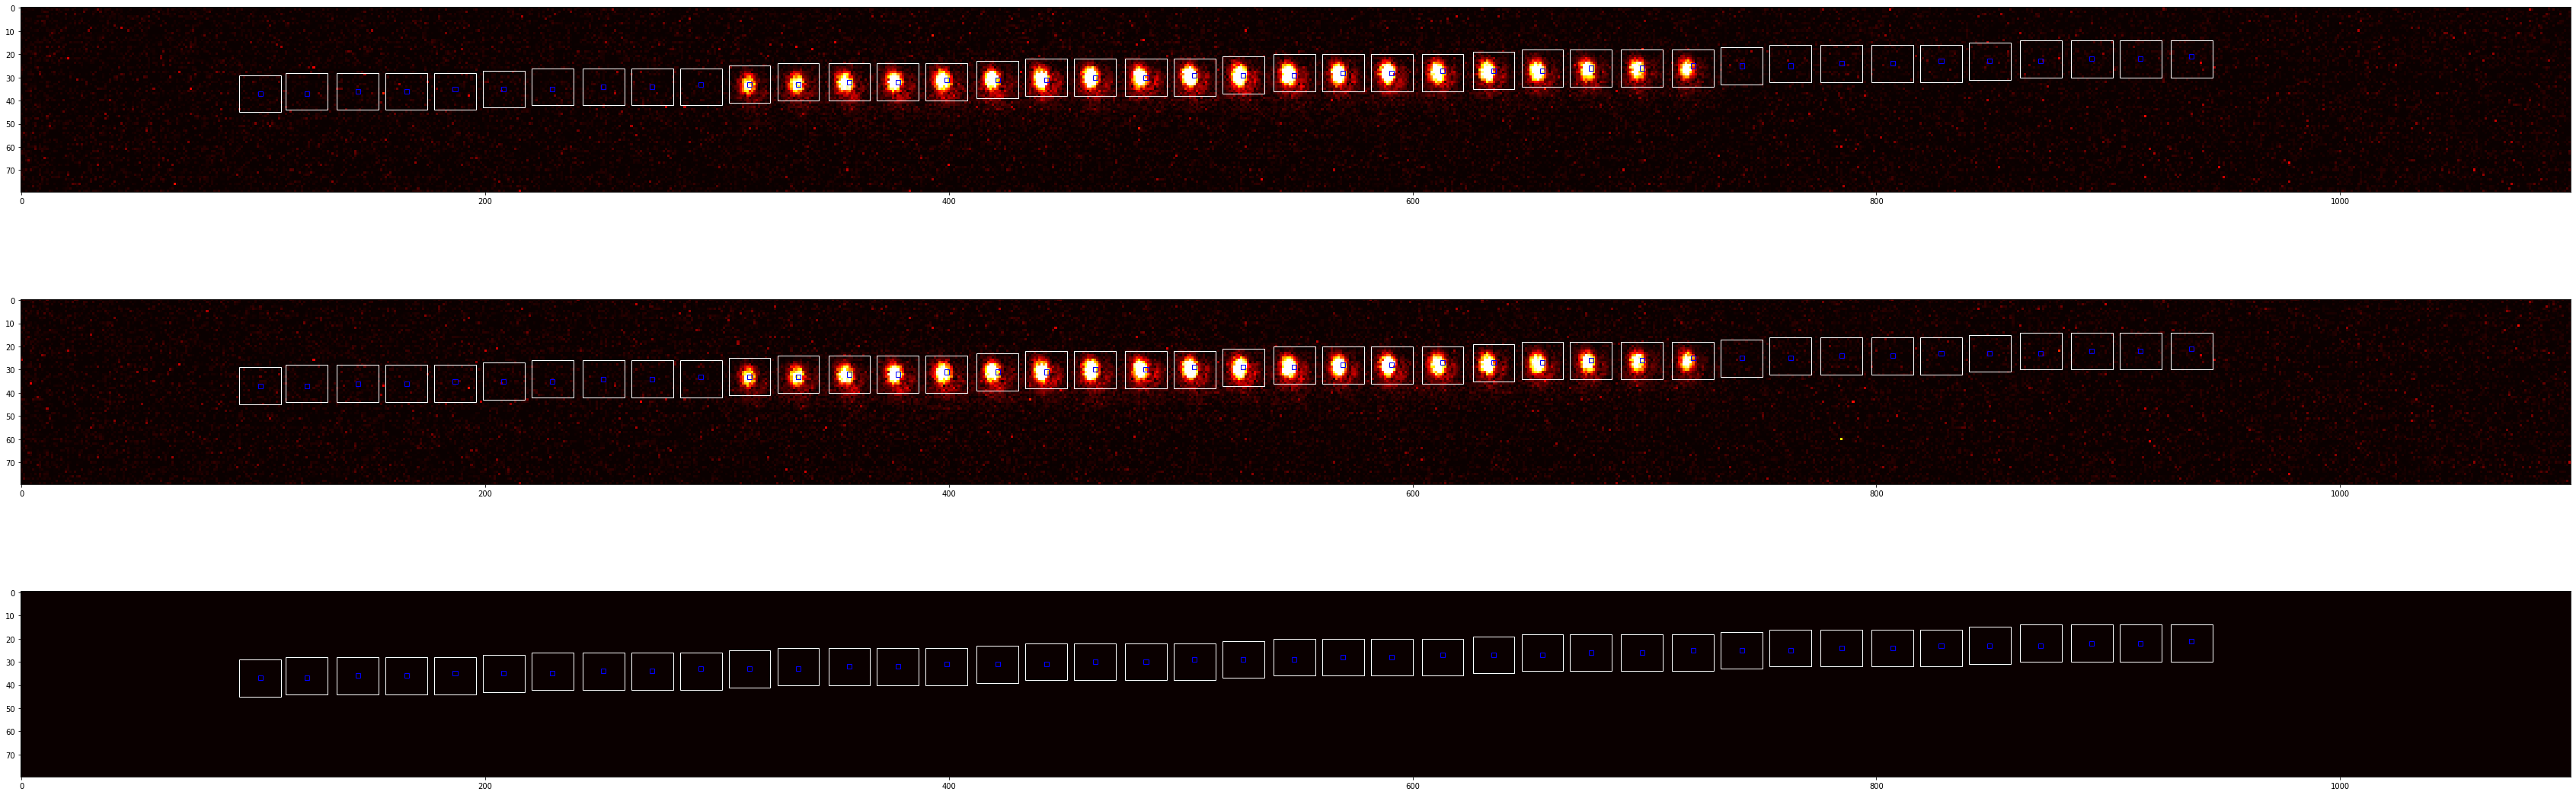

In [ ]:
########################### User input section ############################

select_start = 0 
select_end = num_shots
# select_start = 1000 
# select_end = 2000


mask_select =  (np.arange(num_shots)<select_end) &  (np.arange(num_shots)>=select_start)
mask_plot_data = np.logical_and(mask_select, mask_valid_data)


#Boolean input
###############################################
post_select_true = False
realtime_frequency_zeroing = True
quiet = False
probe_trim = False
odt_freq_center_override = True
plot_many_figures = True
plot_sigma_of_mean = False
###############################################
if plot_sigma_of_mean:
    divider = np.sqrt(num_loops)
else:
    divider = 1


#number input
###############################################
num_start = 0 # This has to be an integer times num_points
num_end = num_shots
num_shots_sliced = num_end - num_start
# num_end = 5000
t_probe_trim = 50 #us #only applied when probe_trim = True
dark_count_threshold=-1
odt_freq_center = -2 #only applied when odt_freq_center_override = True
cav_dark_threshold = 5

# num_frames_cav_per_twz = 1
t_slack_pre = 5
t_slack_post = 5
num_frames_cav = 16
t_pre = 201 #201 #us
t_cav_frame = 1e3+1.97e3 #us  # 80e3/num_frames_cav
t_cav_expo = 0.25e3 #us t_cav_frame #
t_slack = 0 #100 #us
t_gap = 270.065
###############################################

# num_frames_cav = tweezer_num * num_frames_cav_per_twz
t_cav_start=np.array([t_pre+i*t_cav_frame for i in range(num_frames_cav)]) - t_slack_pre
# t_cav_start=np.array([t_pre,t_pre+t_cav_expo,t_pre+2*t_cav_expo,t_pre+3*t_cav_expo+t_gap,t_pre+4*t_cav_expo+t_gap,t_pre+5*t_cav_expo+t_gap])
t_cav_end = t_cav_start + t_cav_expo + t_slack_pre +t_slack_post


#list input
###############################################
upper_threshold_list_F0 = 500*np.ones(num_tweezers)
# upper_threshold_list_F0[-1] = 300
print(upper_threshold_list_F0)
# upper_threshold_list_F0 = [300,300,400,400,400,400,400,400,400,400,400,400,250,250] # counts above ref shot for each tweezer for frame 0
upper_threshold_list_F1 = 500*np.ones(num_tweezers) # counts above ref shot for each tweezer for frame 1
# upper_threshold_list_F1[-1] = 300

upper_threshold_list_F2 = upper_threshold_list_F0 # counts above ref shot for each tweezer for frame 2
upper_threshold_list_F3 = upper_threshold_list_F0
upper_threshold_list_F4 = upper_threshold_list_F0
upper_threshold_list = upper_threshold_list_F0
###############################################
upper_threshold_mat=[upper_threshold_list_F0,upper_threshold_list_F1,upper_threshold_list_F2, upper_threshold_list_F3, upper_threshold_list_F4]


###########################################################################################################

import matplotlib.patches as patches
fig, axs = plt.subplots(num_frames, 1 ,figsize=(60, 20))
for frame_num in range(num_frames):
    axs[ frame_num].imshow(frames_array[frame_num]-frames_array[-1], cmap='hot', interpolation='nearest')
    for tweezer_freq in tweezer_freq_list:
        rect1 = patches.Rectangle((round(roi_center(tweezer_freq)[0] - roi_width/2),round(roi_center(tweezer_freq)[1] - roi_height/2)), roi_width,roi_height,linewidth=1,edgecolor='white',facecolor='none')
        axs[ frame_num].add_patch(rect1)
        rect2 = patches.Rectangle((round(roi_center(tweezer_freq)[0] - 1),round(roi_center(tweezer_freq)[1] - 1)), 2,2,linewidth=1,edgecolor='blue',facecolor='none')
        axs[ frame_num].add_patch(rect2)
#         axs[ frame_num].set_xlim((400,600))
        
for axt in axs:        
    for im in axt.get_images():
        im.set_clim(0, 120)

plt.show()

### Photon count

In [ ]:
def software_gate_batch(time_list,t_pre,N,t_probe,t_cycle):
    mask = np.full(len(time_list),False)
    for i in range(N):
        mask = mask | ((time_list>= t_pre+i*t_cycle) & (time_list<= t_pre+i*t_cycle+t_probe))
    return mask

N_cycle=16
t_probe=0.25e3
t_cycle=1.97e3


def software_gate(time_list, t_start, t_end):
    mask = (time_list>= t_start) & (time_list<= t_end)
    return mask

In [ ]:
# cavity_photoncount_array=np.zeros((num_shots_sliced,num_frames_cav))

# for sliced_i,i in enumerate(range(num_start, num_end)):
#     timestamp_temp=PT_cavity_timestamp_array_raw[i]
#     for j in range(num_frames_cav):
#         mask_temp=(PT_cavity_timestamp_array_raw[i]>=t_cav_start[j] ) & ( PT_cavity_timestamp_array_raw[i]<t_cav_end[j])
#         cavity_photoncount_array[sliced_i,j]=np.sum(software_gate_batch(PT_cavity_timestamp_array_raw[i][mask_temp],t_cav_start[j],N_cycle,t_probe,t_cycle))
                
# cavity_photoncount_array_plot=cavity_photoncount_array



cavity_photoncount_array=np.zeros((num_shots_sliced,num_frames_cav))
cavity_timestamp_array=[]


for sliced_i,i in enumerate(range(num_start, num_end)):
    timestamp_temp=PT_cavity_timestamp_array_raw[i]
    cavity_timestamp_temp = []
    for j in range(num_frames_cav):
        mask_temp=(PT_cavity_timestamp_array_raw[i]>=t_cav_start[j] ) & ( PT_cavity_timestamp_array_raw[i]<t_cav_end[j])
        cavity_photoncount_array[sliced_i,j]=np.sum(software_gate(PT_cavity_timestamp_array_raw[i][mask_temp],t_cav_start[j],t_cav_end[j]))
        cavity_timestamp_temp.append(timestamp_temp[mask_temp])
    cavity_timestamp_array.append(cavity_timestamp_temp)
        
cavity_photoncount_array_plot=cavity_photoncount_array


In [ ]:
gap_list = []
for sliced_i,i in enumerate(range(num_start, num_end)):
    gap_temp = []
    for cav_frame in range(num_frames_cav):
        gap = cavity_timestamp_array[sliced_i][cav_frame][1:] - cavity_timestamp_array[sliced_i][cav_frame][:-1]
        gap_temp.append(gap)
#     if len(np.array(gap)) > 0:
    gap_list.append(gap_temp)
    
    
gap_list_1 = []
for sliced_i,i in enumerate(range(num_start, num_end)):
    for cav_frame in range(num_frames_cav):
        gap = cavity_timestamp_array[sliced_i][cav_frame][1:] - cavity_timestamp_array[sliced_i][cav_frame][:-1]    
        if len(np.array(gap)) > 0:
            gap_list_1.append(gap)

In [ ]:
gap_list_1_concatenated = np.concatenate(gap_list_1)

(0.0, 0.1)

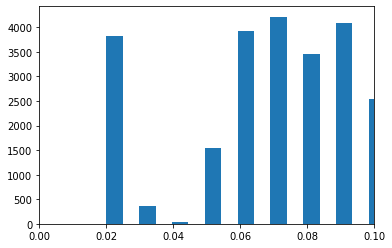

In [ ]:
bins_gap = 200
mask_bins = gap_list_1_concatenated < 1
n = plt.hist(gap_list_1_concatenated[mask_bins], bins=bins_gap)
plt.xlim(0,0.1)
# plt.ylim(0,10000)

In [ ]:
# make the plot
plot = False

if plot:
    atom_site = []
    for i in range(num_frames):
        atom_site.append(np.arange(len(tweezer_freq_list)))
    C_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    bins=50
    for i in range(num_tweezers):
        fig,axs=plt.subplots(ncols=num_frames+1,nrows=1,figsize=[15,6])

        fig.suptitle(f'Tweezer #{i}',fontsize=18)

        plt.sca(axs[0])
        plt.ylabel('Events #',fontsize=12)

        for j in range(num_frames-1):

            plt.sca(axs[j])
            plt.title('Frame {:.0f} Twz Freq = {:.1f}'.format(j,tweezer_freq_list[atom_site[j][i]]),fontsize=15)
            plt.hist(atom_brightness_array[:,j,atom_site[j][i]], alpha=0.75, color=C_cycle[j], bins=bins)
            plt.xlabel('Signal',fontsize=12)
            plt.axvline(upper_threshold_mat[j][i],linestyle='--',color='k')

        plt.sca(axs[-2])

        for j in range(num_frames-1):
            plt.plot(range(atom_brightness_array.shape[0]) , atom_brightness_array[:,j,atom_site[j][i]], marker='.',linestyle='None' ,
                     color=C_cycle[j],alpha=0.8)
            plt.axhline(upper_threshold_mat[j][i],linestyle='--',color=C_cycle[j])
            plt.axvline(select_start,linestyle='--',color='k')
            plt.axvline(select_end,linestyle='--',color='k')

        plt.xlabel('Shot #',fontsize=12)
        plt.ylabel('camera Signal',fontsize=12)



        plt.sca(axs[-1])

    #     for j in range(num_frames_cav):
        plt.plot(range(cavity_photoncount_array.shape[0]) , np.sum(cavity_photoncount_array, axis=1), marker='.',linestyle='None' ,
                 color=C_cycle[j],alpha=0.8)
        plt.axvline(select_start,linestyle='--',color='k')
        plt.axvline(select_end,linestyle='--',color='k')

        plt.xlabel('Shot #',fontsize=12)
        plt.ylabel('spcm Signal',fontsize=12)

        plt.tight_layout()
        plt.show()